In [23]:
import numpy as np
from scipy.io import wavfile
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [17]:
my_file = 'B_S2_D1_067-bebop_000_.wav'

In [18]:
sample_rate, data =  wavfile.read(my_file)


In [37]:
# Read the original recording and create an array with the time of each sample
sample_rate, sample=  wavfile.read(my_file)
sample = np.tile(sample, 100)

sample_length = len(sample)
sample_duration = sample_length/sample_rate
print("The original sample is ", sample_duration, " long")
sample_time = np.linspace(0.0, sample_duration, sample_length)

# Configure our soundscape
speed_of_sound = 343
source_start = np.asarray([150, -50.0, 0.0])



# TODO: We currently assume that things are moving with constant velocity. But this needs to change to a general
# trajectory defined through coordinates.

velocity = np.broadcast_to([[0.0, 10.0, 0.0]], (sample_length, 3))
position = source_start + velocity * (sample_time - sample_time[0])[:, np.newaxis]
mic_locs = np.asarray([
    [0, 0, 0],
    [300, 0, 0],
    [0, 300, 0],
    [300, 300, 0]
])
num_mics = mic_locs.shape[0]

# Calculate the arrival times for each microphone -- 
unit_vectors = mic_locs - position[:, np.newaxis, :]
unit_vectors /= np.linalg.norm(unit_vectors, axis=2, keepdims=True)

# This einsum is basically a dot product between the velocity and the unit vectors
# for each point in time
#  we compute the approach speed as follows -- project the velocity at time t of the donre
# with the unit vector between its current position and the locations of all the microphones
approach_speeds = np.einsum('ij,ikj->ik', velocity, unit_vectors)

# Compute all the distances between the microphones and the drone
distances = cdist(position, mic_locs)

#arrival time  = distance / speed of propagation,  which is approach_speed + speed of sound.
arrival_times = sample_time[:, np.newaxis] + distances / (approach_speeds + speed_of_sound)

# Resample the original recording to get the synthetic recordings
recordings_start = arrival_times[0, :].max()
recordings_end = arrival_times[-1, :].min()
recording_length = recordings_end - recordings_start
recording_samples = int(recording_length * sample_rate)
recordings = np.zeros((num_mics, recording_samples))
recordings_time = np.linspace(recordings_start, recordings_end, recording_samples)

for i in range(num_mics):
    recordings[i, :] = np.interp(recordings_time, arrival_times[:, i], sample, left=0, right=0)

The original sample is  102.4  long


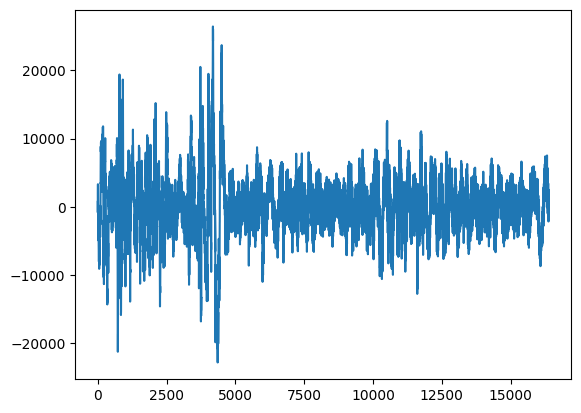

In [43]:
_, data = wavfile.read(my_file)
plt.plot(data)

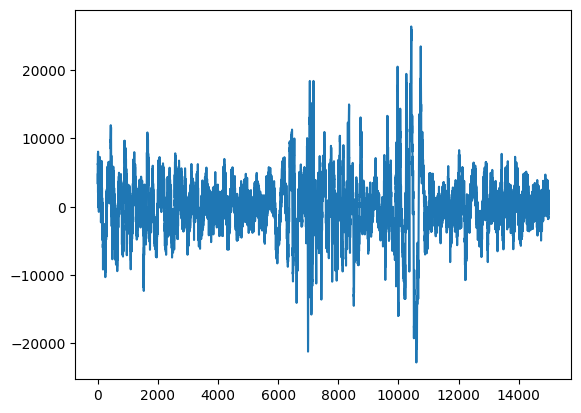

In [46]:
plt.plot(recordings[0,:15000] )


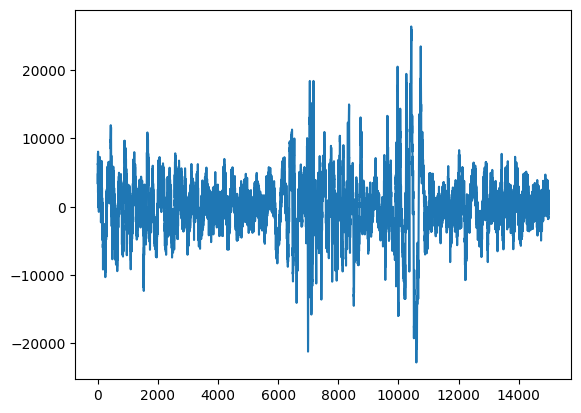

In [48]:
plt.plot(recordings[1,:15000] )


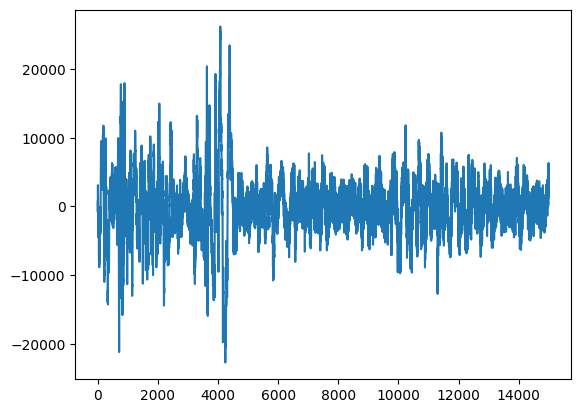

In [49]:
plt.plot(recordings[2,:15000] )


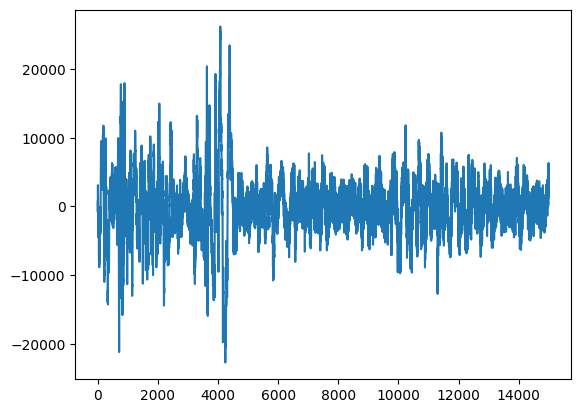

In [50]:
plt.plot(recordings[3,:15000] )